# Georgia Tech ISYE6420 Course Project

### Fall 2023  
### Spencer Vore

In [45]:
import pymc as pm
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

import arviz as az
from collections.abc import Sequence
from typing import Optional

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import seaborn as sns

## Define adjustable Constants / Settings  
Use this to adjust script settings / MCMC run. Sorry, didn't add it to a .env file or something fancier. Works for purpose of demo / tinkering.

In [2]:
n_all = 4000 # Size of data we want for MCMC. Randomly sample this many points from full dataset. Includes train and test sample size.
n_seed = 42 # Random seed for down sampling n datapoints from full dataset

n_test = 2500 # Size of test set we want to saomple from n_all.
split_seed = 43 # Random seed used for train / test split

path_to_datafile = "abalone/abalone.data"

standardize = True # Controls whether to standardize numerical columns

linear_model_n_samples = 50 # how many samples to draw from MCMC for linear model. Set lower for testing. Set higher for official results.
neural_model_n_samples = 500 # how many samples to draw from MCMC for neural model.

## Prepare Dataset

**Load Dataset**

In [3]:
data = pd.read_csv(path_to_datafile, header=None)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
data.shape

(4177, 9)

**Downsample dataset**  
This will help the MCMC algorithm run faster... can adjust upward for better prediction accuracy, or downward for faster computation. Take random sample of data.

In [6]:
# Uncomment this line to use full datasize
# n = data.shape[0]

In [7]:
n = n_all
assert n <= data.shape[0] # Can't chose more samples than size of data
data = data.sample(n, random_state=n_seed)

**Split data into training and test sets**

In [8]:
data.shape

(4000, 9)

In [9]:
assert n_test < n_all # Test size should be smaller than full size
train_data, test_data = train_test_split(data, test_size=n_test, random_state=split_seed)

In [10]:
train_data.shape

(1500, 9)

In [11]:
test_data.shape

(2500, 9)

**Standardize train dataset**  
Not sure if this is nessecary, but doesn't hurt and could help.

In [12]:
class DataPrep:
    '''
    Standardize the data. By writing this as an object, we can save the statistics calculated for the standardization
    so we can use them later to predict new datapoints in our model.
    '''
    def __init__(self):
        self.means = dict()
        self.stdevs = dict()
        
    def prep(self, X_df: pd.DataFrame, X_df_all: Optional[pd.DataFrame] = None, 
             use_prev_standardization=False, standardize=True) -> pd.DataFrame:
        """
        This takes a dataset, and prepares it. Numerical columns are standardized. Categorical columns 
        are one hot encoded so we can fit a numerical regression with a coefficient for each category.
        
        From TA's example github for numerical standardization
        Standardize input variables by 2 std dev.

        For standardization, see:
        https://stat.columbia.edu/~gelman/research/published/standardizing7.pdf
        https://areding.github.io/6420-pymc/unit7/Unit7-arrhythmia.html
        
        INPUTS:
        X_df - The train or test dataset you want to standardize and one hot encode
        X_df_all - The full dataset you sampled X_df from. Used to check that all categorical values in X_df_all are also in X_df. Otherwise,
            you will get an output dataset that doesn't fully one hot encode the full dataset and your dimensions will be off. If this fails,
            you will need to add more logic to this function to handle the edge case. Right now, it just throws and exception.
        use_prev_standardization - Set this to true is X_df is a test set. This will use previously saved means and stdevs from training set 
            (saved in the object) to standardize the test dataset in the same way. If fasle, will recalculate the means and stdev from X_df.
        
        RETURNS:
        Standardized and one hot encoded dataframe based on X_df input
        """
        
        X_standardized = pd.DataFrame()
            
        for colname in X_df.columns:
            col = X_df[colname]
            if is_numeric_dtype(col):
                if standardize:
                    if not use_prev_standardization:
                        self.means[colname] = col.mean()
                        self.stdevs[colname] = col.std()
                    X_standardized[colname] = (col - self.means[colname]) / (2 * self.stdevs[colname])
                else:
                    if not use_prev_standardization:
                        self.means[colname] = None
                        self.stdevs[colname] = None
                    X_standardized[colname] = col
            else:
                X_onehot = pd.get_dummies(X_df[colname], prefix=colname, dtype=int)
                
                # Make sure all categorical values are in subsample. If this breaks,
                # add logic to handle this edge case, such as inserting missing column where 
                # everything is False
                X_onehot_all = pd.get_dummies(X_df_all[colname], prefix=colname, dtype=int)
                assert set(X_onehot.columns) == set(X_onehot_all.columns)
                    
                if X_standardized.empty:
                    X_standardized = X_onehot
                else:
                    X_standardized = X_standardized.join(X_onehot)
                if not use_prev_standardization:
                    onehot_colnames = X_onehot.columns
                    for o_colname in onehot_colnames:
                        self.means[o_colname] = None
                        self.stdevs[o_colname] = None

        return X_standardized


In [13]:
data_preper = DataPrep()
train_data_std = data_preper.prep(X_df = train_data, X_df_all = data, standardize=standardize)

In [14]:
train_data_std.head()

,0_F,0_I,0_M,1,2,3,4,5,6,7,8
1335,1,0,0,0.200543,0.349441,0.317187,0.234926,0.322179,0.113948,0.227865,-0.147831
2944,0,0,1,0.425458,0.498294,0.380956,0.346071,0.278599,0.552176,0.377577,-0.458618
542,0,0,1,-0.433309,-0.419634,-0.320503,-0.559187,-0.596337,-0.575018,-0.458314,0.784530
1128,1,0,0,0.139202,0.150970,0.189649,-0.205130,-0.068917,-0.035140,0.010426,-0.303224
1870,0,1,0,0.016521,0.101352,-0.001658,-0.168417,-0.153841,-0.396564,-0.043042,-0.303224


In [15]:
train_data_std.shape

(1500, 11)

In [16]:
data_preper.means

{'0_F': None,
 '0_I': None,
 '0_M': None,
 1: 0.52596,
 2: 0.4095733333333333,
 3: 0.14013,
 4: 0.8444386666666666,
 5: 0.3668376666666666,
 6: 0.18427800000000003,
 7: 0.24207499999999996,
 8: 9.951333333333332}

In [17]:
data_preper.stdevs

{'0_F': None,
 '0_I': None,
 '0_M': None,
 1: 0.12226833099038954,
 2: 0.10077047061211507,
 3: 0.039204052577410005,
 4: 0.49709575103329184,
 5: 0.22373050315036502,
 6: 0.1106730759300738,
 7: 0.14026943674558362,
 8: 3.217638941179192}

In [18]:
X_train = train_data_std.drop(8, axis=1).to_numpy()
y_train = train_data_std[8].to_numpy()

In [19]:
X_train

array([[ 1.        ,  0.        ,  0.        , ...,  0.32217854,
         0.11394822,  0.22786503],
       [ 0.        ,  0.        ,  1.        , ...,  0.27859932,
         0.55217585,  0.37757691],
       [ 0.        ,  0.        ,  1.        , ..., -0.59633725,
        -0.5750179 , -0.45831438],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.50582657,
        -0.38752876, -0.50643605],
       [ 0.        ,  1.        ,  0.        , ..., -0.77735861,
        -0.78283719, -0.8165535 ],
       [ 0.        ,  1.        ,  0.        , ..., -0.62650748,
        -0.64278506, -0.61337311]])

**Apply standardization to test dataset**

In [20]:
test_data_std = data_preper.prep(X_df = test_data, X_df_all = data, use_prev_standardization=True, standardize=standardize)

In [21]:
test_data_std.head()

,0_F,0_I,0_M,1,2,3,4,5,6,7,8
2194,0,1,0,-0.392416,-0.419634,-0.384271,-0.479725,-0.517001,-0.410118,-0.435145,0.473743
2879,0,1,0,-0.228841,-0.121927,-0.129196,-0.258943,-0.229825,-0.303949,-0.242658,-0.303224
3320,1,0,0,0.036968,0.076544,0.189649,-0.068336,-0.144901,-0.125496,0.028249,0.939923
691,0,1,0,-1.108055,-1.089473,-0.830654,-0.762367,-0.742719,-0.739918,-0.773779,-0.769405
3415,1,0,0,0.139202,0.275014,0.253418,0.188154,0.145627,0.082324,0.338367,-0.147831


In [22]:
test_data_std.shape

(2500, 11)

In [23]:
X_test = test_data_std.drop(8, axis=1).to_numpy()
y_test = test_data_std[8].to_numpy()

In [24]:
y_test[:40]

array([ 0.47374282, -0.30322441,  0.93992315, -0.76940474, -0.14783096,
        0.00756248, -0.14783096,  1.56149693, -0.14783096, -0.14783096,
       -0.14783096, -0.14783096,  0.31834937,  0.16295593,  0.16295593,
        0.00756248, -0.45861785, -0.45861785,  0.16295593,  0.31834937,
        0.00756248, -0.6140113 ,  0.00756248,  0.00756248, -0.45861785,
       -0.14783096,  0.00756248,  0.16295593, -0.14783096, -0.14783096,
        0.00756248, -0.6140113 , -0.76940474,  0.16295593,  0.93992315,
        0.31834937, -0.45861785, -0.30322441,  0.00756248,  0.16295593])

## Fit linear regression model

Some examples that were referenced:  
https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust.html  
https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-out-of-sample-predictions.html  

In [25]:
with pm.Model() as m_linear:
    # associate data with model (this makes prediction easier)
    X_data = pm.Data("X", X_train, mutable=True)
    y_data = pm.Data("y", y_train, mutable=True)
    
    intercept = pm.StudentT("intercept", mu=0, sigma=5, nu=3)
    coeffs = pm.StudentT("coeffs", mu=0, sigma=5, nu=3, shape=X_data.shape[1])
    sigma = pm.HalfCauchy("sigma", beta=10)

    mu = intercept + pm.math.dot(X_data, coeffs)

    # likelihood
    pm.StudentT("age_of_tree", mu=mu, sigma=sigma, nu=3, observed=y_data)

    # start sampling
    trace_linear = pm.sample(linear_model_n_samples)
    ppc = pm.sample_posterior_predictive(trace_linear)
    
    y_pred = ppc.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coeffs, sigma]


Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 137 seconds.
The number of samples is too small to check convergence reliably.
Sampling: [age_of_tree]


In [26]:
y_pred.shape

(1500,)

In [27]:
az.summary(trace_linear, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.272,2.114,-3.557,4.293,0.261,0.186,67.0,136.0,1.04
coeffs[0],-0.315,2.113,-4.334,3.511,0.262,0.186,66.0,136.0,1.04
coeffs[1],-0.386,2.114,-4.400,3.455,0.261,0.185,67.0,136.0,1.04
coeffs[2],-0.278,2.114,-4.303,3.544,0.261,0.185,67.0,136.0,1.04
coeffs[3],0.009,0.092,-0.157,0.188,0.008,0.006,119.0,120.0,1.01
coeffs[4],0.290,0.101,0.085,0.487,0.009,0.007,116.0,126.0,1.01
coeffs[5],0.209,0.039,0.136,0.276,0.003,0.002,181.0,156.0,1.02
coeffs[6],1.409,0.208,1.091,1.857,0.025,0.018,78.0,72.0,1.02
coeffs[7],-1.268,0.111,-1.476,-1.081,0.013,0.009,74.0,109.0,1.03
coeffs[8],-0.362,0.067,-0.485,-0.238,0.006,0.004,128.0,155.0,1.01


Above, coefficients 4, 5, 6, 7, 8, and 9 appear statistically significant as their CS doesn't contain zero. Maybe retry regression and drop these other variables.

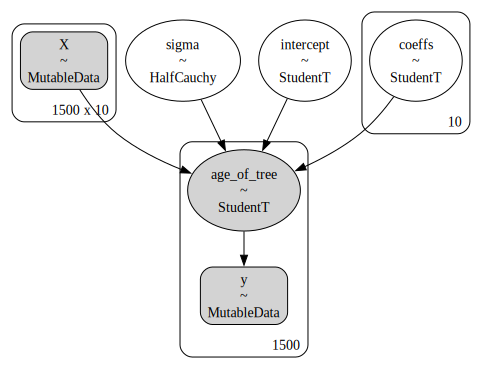

In [28]:
pm.model_to_graphviz(m_linear)

In [29]:
az.r2_score(y_train, y_pred)

r2        0.518961
r2_std    0.000000
dtype: float64

In [30]:
round(mean_squared_error(y_train, y_pred), 4)

0.1156

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

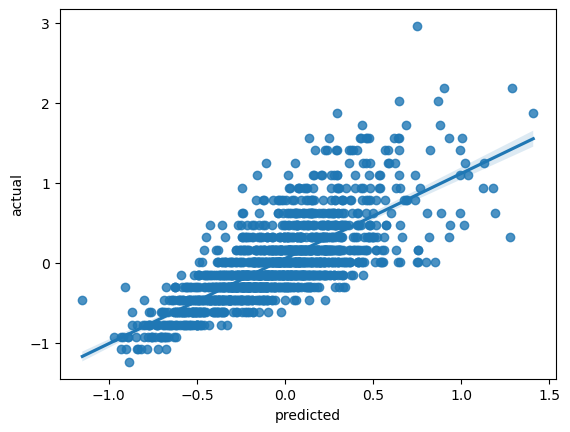

In [31]:
plot = sns.regplot(x=y_pred, y=y_train)
plot.set(xlabel="predicted", ylabel="actual")

**Now lets predict the test set**

First prediction without sampling... just use coefficients

In [32]:
pred_intercept = trace_linear.posterior.intercept.mean().values.item()
pred_coeffs = trace_linear.posterior.coeffs.mean(["chain", "draw"]).values
y_pred_test_nosample = X_test @  pred_coeffs + pred_intercept

In [33]:
round(mean_squared_error(y_test, y_pred_test_nosample), 4)

0.1246

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

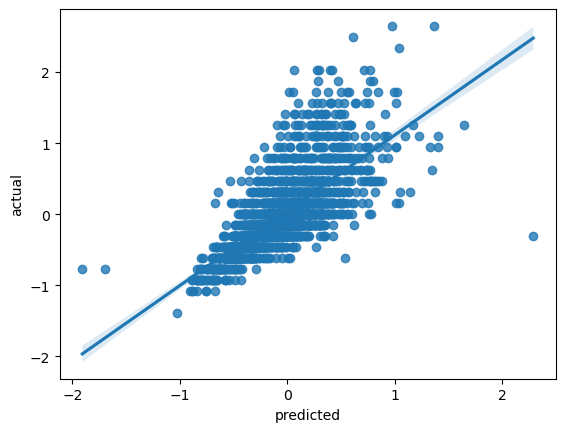

In [34]:
plot = sns.regplot(x=y_pred_test_nosample, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

Now predict using sampling

In [35]:
with m_linear:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test = pm.sample_posterior_predictive(trace_linear) #, predictions=True)
    y_pred_test = ppc_test.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs]


In [36]:
round(mean_squared_error(y_test, y_pred_test), 4)

2.1736

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

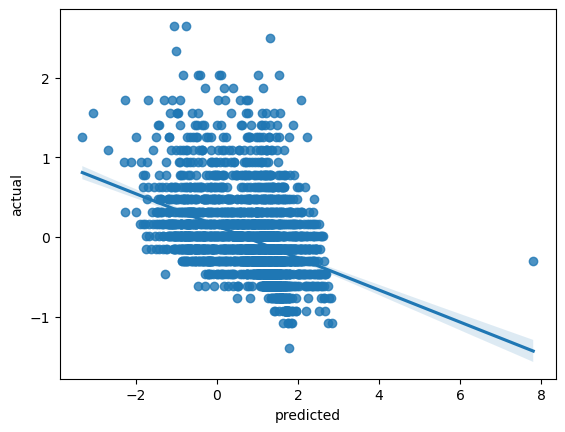

In [37]:
plot = sns.regplot(x=y_pred_test, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

The sampling on the test set seems very unstable. Note how we can get two very different results when we redraw the samples.

In [38]:
with m_linear:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test = pm.sample_posterior_predictive(trace_linear) #, predictions=True)
    y_pred_test = ppc_test.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs]


In [39]:
round(mean_squared_error(y_test, y_pred_test), 4)

1.8171

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

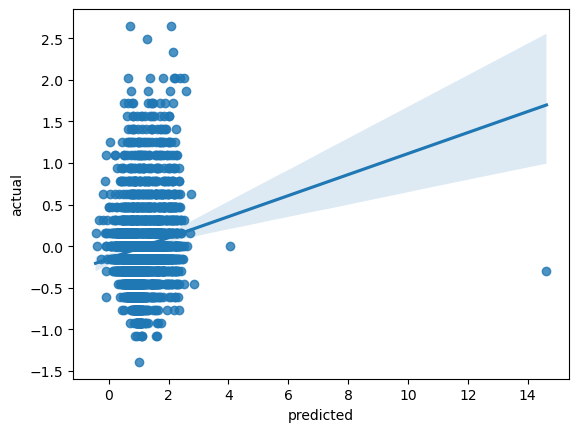

In [40]:
plot = sns.regplot(x=y_pred_test, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

## Fit Neural Network Model

**Now let's try and build a simple neural network, with 3 neurons. We will keep it small to limit computational complexity.**

In [52]:
# naming convention. N for neuron. First number is layer. Second is neuron number in that layer. 
# So n21 is the first neuron in layer 2.
with pm.Model() as m_neural:
    # associate data with model (this makes prediction easier)
    X_data_n = pm.Data("X", X_train, mutable=True)
    y_data_n = pm.Data("y", y_train, mutable=True)
    
    # LAYER 1
    
    # NEURON 1-0
    intercept_n10 = pm.StudentT("intercept_n10", mu=0, sigma=5, nu=3)
    coeffs_n10 = pm.StudentT("coeffs_n10", mu=0, sigma=5, nu=3, shape=X_data_n.shape[1])
    
    mu_n10 = intercept_n10 + pm.math.dot(X_data_n, coeffs_n10)
    
    # ReLU function
    out_n10 = pm.Deterministic("out_n10", pm.math.maximum(0, mu_n10))
        
    sigma_n10 = pm.HalfCauchy("sigma_n10", beta=10)
    

    # NEURON 1-1
    intercept_n11 = pm.StudentT("intercept_n11", mu=0, sigma=5, nu=3)
    coeffs_n11 = pm.StudentT("coeffs_n11", mu=0, sigma=5, nu=3, shape=X_data_n.shape[1])
    
    mu_n11 = intercept_n11 + pm.math.dot(X_data_n, coeffs_n11)
    
    # ReLU function
    out_n11 = pm.Deterministic("out_n11", pm.math.maximum(0, mu_n11))
    sigma_n11 = pm.HalfCauchy("sigma_n11", beta=10)

    
    # NEURON 1-2
    intercept_n12 = pm.StudentT("intercept_n12", mu=0, sigma=5, nu=3)
    coeffs_n12 = pm.StudentT("coeffs_n12", mu=0, sigma=5, nu=3, shape=X_data_n.shape[1])
    
    mu_n12 = intercept_n12 + pm.math.dot(X_data_n, coeffs_n12)
    
    # ReLU function
    out_n12 = pm.Deterministic("out_n12", pm.math.maximum(0, mu_n12))
    
    sigma_n12 = pm.HalfCauchy("sigma_n12", beta=10)


    
    # NEURON 2-0
    intercept_n20 = pm.StudentT("intercept_n20", mu=0, sigma=5, nu=3)
    coeff_n20_0 = pm.StudentT("coeff_n20_0", mu=0, sigma=sigma_n10, nu=3) # input coeff for neron 10
    coeff_n20_1 = pm.StudentT("coeff_n20_1", mu=0, sigma=sigma_n11, nu=3) # input coeff for neron 11
    coeff_n20_2 = pm.StudentT("coeff_n20_2", mu=0, sigma=sigma_n12, nu=3) # input coeff for neron 12

    # Had a hard time getting this to work as an array / dot product, so just do it manually
    mu_n20 = (intercept_n20 
              + out_n10 * coeff_n20_0 
              + out_n11 * coeff_n20_1
              + out_n12 * coeff_n20_2)

    sigma_n20 = pm.HalfCauchy("sigma_n20", beta=10)

    # likelihood - just take linear combination as regression
    pm.StudentT("age_of_tree", mu=mu_n20, sigma=sigma_n20, nu=3, observed=y_data_n)

    # start sampling
    trace_neural = pm.sample(neural_model_n_samples)
    ppc_neural = pm.sample_posterior_predictive(trace_neural)
    
    y_pred_neural = ppc_neural.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_n10, coeffs_n10, sigma_n10, intercept_n11, coeffs_n11, sigma_n11, intercept_n12, coeffs_n12, sigma_n12, intercept_n20, coeff_n20_0, coeff_n20_1, coeff_n20_2, sigma_n20]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 496 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [age_of_tree]


In [53]:
y_pred_neural.shape

(1500,)

In [85]:
az.summary(trace_neural, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept_n10,2.095,6.788,-8.579,18.813,2.475,1.823,7.0,42.0,1.56
coeffs_n10[0],0.242,2.955,-5.615,6.082,0.221,0.157,141.0,692.0,1.03
coeffs_n10[1],2.651,6.192,-6.517,15.844,2.119,1.553,8.0,334.0,1.47
coeffs_n10[2],-0.581,3.095,-6.097,5.892,0.540,0.385,32.0,420.0,1.09
coeffs_n10[3],-4.614,6.078,-18.226,5.073,1.307,0.937,17.0,81.0,1.17
...,...,...,...,...,...,...,...,...,...
out_n12[1495],4.546,5.261,0.000,14.060,2.273,1.704,5.0,5.0,2.07
out_n12[1496],3.563,4.087,0.000,11.203,1.744,1.305,6.0,6.0,1.98
out_n12[1497],12.097,10.221,0.657,31.364,4.125,3.068,6.0,156.0,1.74
out_n12[1498],14.192,15.632,0.000,42.860,6.677,4.998,6.0,27.0,1.79


Above, coefficients 4, 5, 6, 7, 8, and 9 appear statistically significant as their CS doesn't contain zero. Maybe retry regression and drop these other variables.

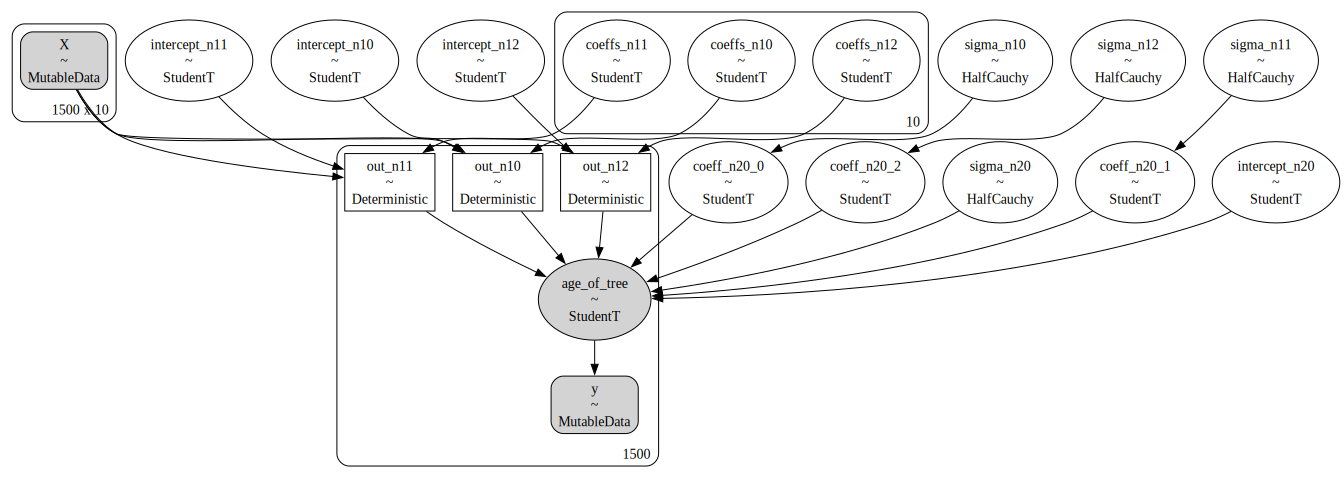

In [55]:
# This chart will sort of visualize our neural network structure.
pm.model_to_graphviz(m_neural)

In [56]:
az.r2_score(y_train, y_pred_neural)

r2        0.584756
r2_std    0.000000
dtype: float64

In [57]:
round(mean_squared_error(y_train, y_pred_neural), 4)

0.1002

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

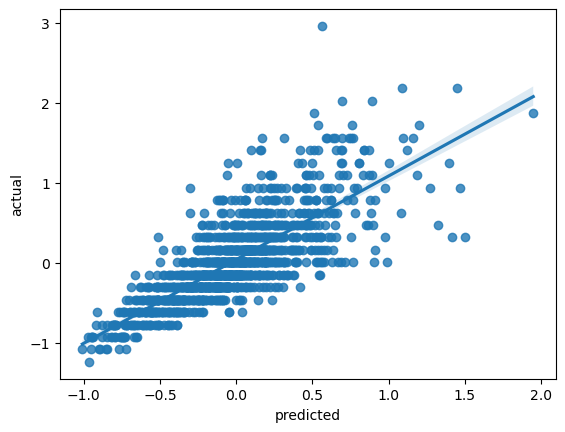

In [58]:
plot = sns.regplot(x=y_pred_neural, y=y_train)
plot.set(xlabel="predicted", ylabel="actual")

**Now lets predict the test set**

First prediction without sampling... just use coefficients. Kind of a hassle to extract all these individually to recrate the neural network math... I'm trying to be careful.
Hopefully no mistakes. :)

In [74]:
# LAYER 1
pred_intercept_n10 = trace_neural.posterior.intercept_n10.mean().values.item()
pred_intercept_n11 = trace_neural.posterior.intercept_n11.mean().values.item()
pred_intercept_n12 = trace_neural.posterior.intercept_n12.mean().values.item()

pred_coeffs_n10 = trace_neural.posterior.coeffs_n10.mean(["chain", "draw"]).values
pred_coeffs_n11 = trace_neural.posterior.coeffs_n11.mean(["chain", "draw"]).values
pred_coeffs_n12 = trace_neural.posterior.coeffs_n12.mean(["chain", "draw"]).values

# Data X coefficients, then ReLU
pred_out_n10 = np.maximum(0, pred_intercept_n10 + X_test @ pred_coeffs_n10)
pred_out_n11 = np.maximum(0, pred_intercept_n11 + X_test @ pred_coeffs_n11)
pred_out_n12 = np.maximum(0, pred_intercept_n12 + X_test @ pred_coeffs_n12)

# LAYER 2
pred_intercept_n20 = trace_neural.posterior.intercept_n20.mean().values.item()
pred_coeff_n20_0 = trace_neural.posterior.coeff_n20_0.mean().values.item()
pred_coeff_n20_1 = trace_neural.posterior.coeff_n20_1.mean().values.item()
pred_coeff_n20_2 = trace_neural.posterior.coeff_n20_2.mean().values.item()

y_pred_test_nosample_neural = (pred_intercept_n20 
          + pred_out_n10 * pred_coeff_n20_0 
          + pred_out_n11 * pred_coeff_n20_1
          + pred_out_n12 * pred_coeff_n20_2)

In [75]:
round(mean_squared_error(y_test, y_pred_test_nosample_neural), 4)

0.3521

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

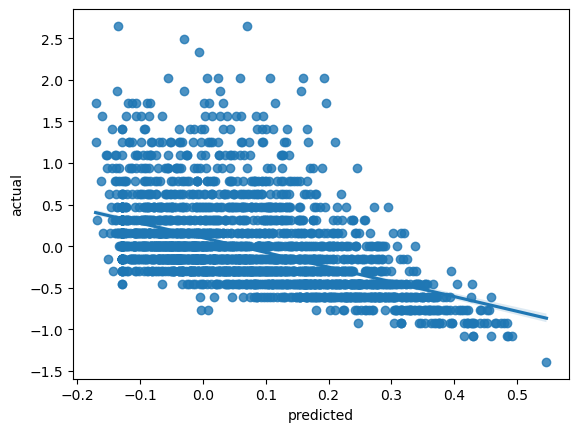

In [76]:
plot = sns.regplot(x=y_pred_test_nosample_neural, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

Now predict using sampling  
**We are now getting a much lower MSA values, and they seem more stable. The neural net seems to be much better at dealing with possible outliers and non-linearities than the linear model**

In [77]:
with m_neural:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test_neural = pm.sample_posterior_predictive(trace_neural) #, predictions=True)
    y_pred_test_neural = ppc_test_neural.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs_n10, coeffs_n11, coeffs_n12]


In [78]:
round(mean_squared_error(y_test, y_pred_test_neural), 4)

0.2736

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

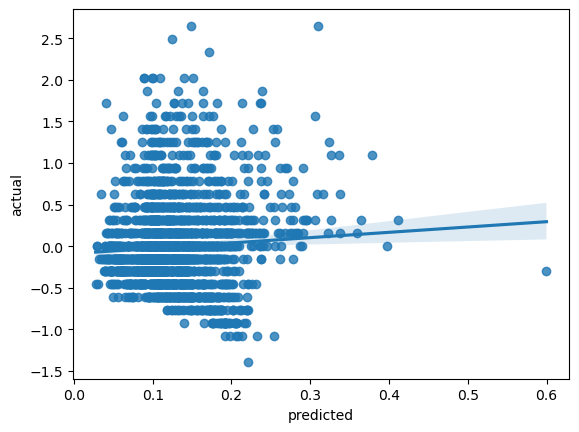

In [79]:
plot = sns.regplot(x=y_pred_test_neural, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

The sampling on the test set seems very unstable. Note how we can get two very different results when we redraw the samples.

In [80]:
with m_neural:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test_neural = pm.sample_posterior_predictive(trace_neural) #, predictions=True)
    y_pred_test_neural = ppc_test_neural.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs_n10, coeffs_n11, coeffs_n12]


In [81]:
round(mean_squared_error(y_test, y_pred_test_neural), 4)

0.2586

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

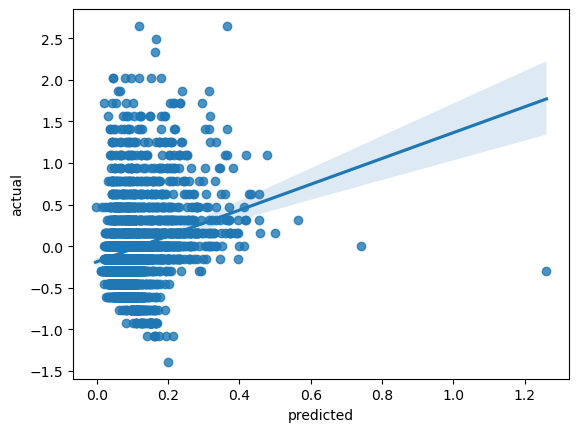

In [82]:
plot = sns.regplot(x=y_pred_test_neural, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

In [66]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Sat Dec 02 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.15.0

pytensor: 2.17.3

numpy  : 1.25.2
seaborn: 0.13.0
pandas : 2.1.3
arviz  : 0.16.1
pymc   : 5.9.1



# --------------------------------